In [6]:
%load_ext autoreload
%autoreload 3

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")
import networkx as nx
import scipy
import sklearn
import time
import pickle
import warnings

# methods
from gaccord import GraphicalAccord, GraphicalConcord
from inverse_covariance import QuicGraphicalLasso
from rpy2.robjects.packages import importr
import rpy2.robjects.numpy2ri

# utils
import sys
sys.path.append('../utils')
from utils import partial_corr, compute_tp_fp, mcc, precision_recall, pseudo_BIC, gauss_BIC, proj_precision_mat
from generate_graphs import generate_erdos_renyi, generate_data

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Get graph and data (hub-network)

In [2]:
# we use pre-made hub-network graph structure, which was constructed by the following procedure:
# (1) create a Barabasi-Albert scale-free graph
# (2) randomly choose 5% of the nodes to be hub nodes
# (3) for each hub node, construct a complete sub-graph (clique)
Skel = np.genfromtxt('../data/hub-network-structure.txt', delimiter=',')

n, p = 500, 1000
n_prop_to_p = [0.5]
random_state = 2023
lower_weight, upper_weight = 0.5, 1.0
spread_diag=[1, np.sqrt(3)]

# projection method
np.random.seed(random_state)
edge_weights = np.random.uniform(low=lower_weight, high=upper_weight, size=(p,p))
edge_signs = np.random.choice([-1,1], size=(p,p))
Theta = np.multiply(edge_weights, edge_signs)
Theta = np.multiply(Skel, Theta)
Theta = np.tril(Theta) + np.tril(Theta).T
nz_indx = np.nonzero(Theta)
for i in range(100):
    Theta = proj_precision_mat(Theta, nz_indx)
    if np.linalg.cond(Theta) < 20:
        break

Theta = np.real(Theta)
Partial_corr = partial_corr(Theta)
Sigma = np.linalg.inv(Theta)

Xs = generate_data(p, n_prop_to_p, Sigma, N=1, random_state=2023)
X = Xs[0]

### Get graph and data (Erdos-Renyi)

In [2]:
n, p = 500, 1000
n_prop_to_p = [0.5]
Theta, Sigma = generate_erdos_renyi(p, n_prop_to_p, type='proj', edge_prob=0.01, lower_weight=0.5, upper_weight=1.0, spread_diag=[1, np.sqrt(3)], random_state=2023)
Partial_corr = partial_corr(Theta)

Xs = generate_data(p, n_prop_to_p, Sigma, N=1, random_state=2023)
X = Xs[0]

### Run ACCORD, CONCORD, Glasso

In [4]:
S = np.matmul(X.T, X)/n
S.flat[::S.shape[0] + 1] = 0
lam_max = np.max(np.abs(S))
lam_min = 0.1 * lam_max
lams = np.logspace(np.log10(lam_min), np.log10(lam_max), 30)

# lams = lams[::-1][14:26] # pre-selected lambdas for hub-network
lams = lams[::-1][7:19] # pre-selected lambdas for erdos-renyi

accord_nz, accord_precs, accord_recalls, accord_mccs = [], [], [], []
concord_nz, concord_precs, concord_recalls, concord_mccs = [], [], [], []
glasso_nz, glasso_precs, glasso_recalls, glasso_mccs = [], [], [], []

p_bics, ep_bics_01, ep_bics_02, gauss_bics = [], [], [], []

for lam in lams:
    # ACCORD
    model = GraphicalAccord(Omega_star=np.eye(p), lam1=lam, lam2=0.0, stepsize_multiplier=2.0, backtracking=True, epstol=1e-5, maxitr=500, penalize_diag=True)
    model.fit(X)
    Omega_hat = model.omega_.toarray()
    Theta_hat = 0.5 * ((np.diag(np.diag(Omega_hat)) @ Omega_hat) + (Omega_hat.T @ np.diag(np.diag(Omega_hat))))
    
    p_bics.append(pseudo_BIC(X, Theta_hat, type='edge', modified=False))
    ep_bics_01.append(pseudo_BIC(X, Theta_hat, type='edge', modified=True, gamma=0.1))
    ep_bics_02.append(pseudo_BIC(X, Theta_hat, type='edge', modified=True, gamma=0.2))
    gauss_bics.append(gauss_BIC(X, Theta_hat, type='edge'))
    
    accord_nz.append(len(np.flatnonzero(Theta_hat))-p)
    prec, recall = precision_recall(Theta, Theta_hat)
    accord_precs.append(prec)
    accord_recalls.append(recall)
    accord_mccs.append(mcc(Theta, Theta_hat))

    # CONCORD
    model = GraphicalConcord(Omega_star=np.eye(p), lam1=lam, lam2=0.0, constant_stepsize=0.0, backtracking=True, epstol=1e-5, maxitr=500, penalize_diag=True)
    model.fit(X)
    Theta_hat = model.omega_.toarray()
    
    concord_nz.append(len(np.flatnonzero(Theta_hat))-p)
    prec, recall = precision_recall(Theta, Theta_hat)
    concord_precs.append(prec)
    concord_recalls.append(recall)
    concord_mccs.append(mcc(Theta, Theta_hat))
    
    # Glasso
    quic = QuicGraphicalLasso(lam=lam).fit(X)
    Theta_hat = quic.precision_
    
    glasso_nz.append(len(np.flatnonzero(Theta_hat))-p)
    prec, recall = precision_recall(Theta, Theta_hat)
    glasso_precs.append(prec)
    glasso_recalls.append(recall)
    glasso_mccs.append(mcc(Theta, Theta_hat))

### Run SPACE

In [5]:
%%capture

# import SPACE
rpy2.robjects.numpy2ri.activate()
space = importr('space')

# lams = np.logspace(np.log10(100), np.log10(200), 20) # pre-selected lambdas for hub-network
lams = np.logspace(np.log10(100), np.log10(200), 20) # pre-selected lambdas for erdos-renyi

space_nz, space_precs, space_recalls, space_mccs = [], [], [], []

for lam in lams:
    prec = space.space_joint(X, np.array([lam]))
    Theta_hat = np.array(prec[0])

    space_nz.append(len(np.flatnonzero(Theta_hat))-p)
    prec, recall = precision_recall(Theta, Theta_hat)
    space_precs.append(prec)
    space_recalls.append(recall)
    space_mccs.append(mcc(Theta, Theta_hat))

In [7]:
# save results (hub-network)
# np.savetxt('data/hub_network_p_bics.txt', p_bics, fmt='%s', delimiter=',')
# np.savetxt('data/hub_network_ep_bics_01.txt', ep_bics_01, fmt='%s', delimiter=',')
# np.savetxt('data/hub_network_ep_bics_02.txt', ep_bics_02, fmt='%s', delimiter=',')
# np.savetxt('data/hub_network_gauss_bics.txt', gauss_bics, fmt='%s', delimiter=',')

# np.savetxt('data/hub_network_accord_nz.txt', accord_nz, fmt='%s', delimiter=',')
# np.savetxt('data/hub_network_accord_precs.txt', accord_precs, fmt='%s', delimiter=',')
# np.savetxt('data/hub_network_accord_recalls.txt', accord_recalls, fmt='%s', delimiter=',')
# np.savetxt('data/hub_network_accord_mccs.txt', accord_mccs, fmt='%s', delimiter=',')

# np.savetxt('data/hub_network_concord_nz.txt', concord_nz, fmt='%s', delimiter=',')
# np.savetxt('data/hub_network_concord_precs.txt', concord_precs, fmt='%s', delimiter=',')
# np.savetxt('data/hub_network_concord_recalls.txt', concord_recalls, fmt='%s', delimiter=',')
# np.savetxt('data/hub_network_concord_mccs.txt', concord_mccs, fmt='%s', delimiter=',')

# np.savetxt('data/hub_network_glasso_nz.txt', glasso_nz, fmt='%s', delimiter=',')
# np.savetxt('data/hub_network_glasso_precs.txt', glasso_precs, fmt='%s', delimiter=',')
# np.savetxt('data/hub_network_glasso_recalls.txt', glasso_recalls, fmt='%s', delimiter=',')
# np.savetxt('data/hub_network_glasso_mccs.txt', glasso_mccs, fmt='%s', delimiter=',')

# np.savetxt('data/hub_network_space_nz.txt', space_nz, fmt='%s', delimiter=',')
# np.savetxt('data/hub_network_space_precs.txt', space_precs, fmt='%s', delimiter=',')
# np.savetxt('data/hub_network_space_recalls.txt', space_recalls, fmt='%s', delimiter=',')
# np.savetxt('data/hub_network_space_mccs.txt', space_mccs, fmt='%s', delimiter=',')

In [6]:
# save results (erdos-renyi)
np.savetxt('data/erdos_renyi_p_bics.txt', p_bics, fmt='%s', delimiter=',')
np.savetxt('data/erdos_renyi_ep_bics_01.txt', ep_bics_01, fmt='%s', delimiter=',')
np.savetxt('data/erdos_renyi_ep_bics_02.txt', ep_bics_02, fmt='%s', delimiter=',')
np.savetxt('data/erdos_renyi_gauss_bics.txt', gauss_bics, fmt='%s', delimiter=',')

np.savetxt('data/erdos_renyi_accord_nz.txt', accord_nz, fmt='%s', delimiter=',')
np.savetxt('data/erdos_renyi_accord_precs.txt', accord_precs, fmt='%s', delimiter=',')
np.savetxt('data/erdos_renyi_accord_recalls.txt', accord_recalls, fmt='%s', delimiter=',')
np.savetxt('data/erdos_renyi_accord_mccs.txt', accord_mccs, fmt='%s', delimiter=',')

np.savetxt('data/erdos_renyi_concord_nz.txt', concord_nz, fmt='%s', delimiter=',')
np.savetxt('data/erdos_renyi_concord_precs.txt', concord_precs, fmt='%s', delimiter=',')
np.savetxt('data/erdos_renyi_concord_recalls.txt', concord_recalls, fmt='%s', delimiter=',')
np.savetxt('data/erdos_renyi_concord_mccs.txt', concord_mccs, fmt='%s', delimiter=',')

np.savetxt('data/erdos_renyi_glasso_nz.txt', glasso_nz, fmt='%s', delimiter=',')
np.savetxt('data/erdos_renyi_glasso_precs.txt', glasso_precs, fmt='%s', delimiter=',')
np.savetxt('data/erdos_renyi_glasso_recalls.txt', glasso_recalls, fmt='%s', delimiter=',')
np.savetxt('data/erdos_renyi_glasso_mccs.txt', glasso_mccs, fmt='%s', delimiter=',')

np.savetxt('data/erdos_renyi_space_nz.txt', space_nz, fmt='%s', delimiter=',')
np.savetxt('data/erdos_renyi_space_precs.txt', space_precs, fmt='%s', delimiter=',')
np.savetxt('data/erdos_renyi_space_recalls.txt', space_recalls, fmt='%s', delimiter=',')
np.savetxt('data/erdos_renyi_space_mccs.txt', space_mccs, fmt='%s', delimiter=',')

### Load saved results

In [8]:
# load hub-network results
p_bics_hub = np.genfromtxt('data/hub_network_p_bics.txt', delimiter=',')
ep_bics_01_hub = np.genfromtxt('data/hub_network_ep_bics_01.txt', delimiter=',')
ep_bics_02_hub = np.genfromtxt('data/hub_network_ep_bics_02.txt', delimiter=',')
gauss_bics_hub = np.genfromtxt('data/hub_network_gauss_bics.txt', delimiter=',')
best_p_bic_hub = np.argmin(p_bics_hub)
best_ep_bic_01_hub = np.argmin(ep_bics_01_hub)
best_ep_bic_02_hub = np.argmin(ep_bics_02_hub)
best_gauss_bic_hub = np.argmin(gauss_bics_hub)

accord_nz_hub = np.genfromtxt('data/hub_network_accord_nz.txt', delimiter=',')
accord_precs_hub = np.genfromtxt('data/hub_network_accord_precs.txt', delimiter=',')
accord_recalls_hub = np.genfromtxt('data/hub_network_accord_recalls.txt', delimiter=',')
accord_mccs_hub = np.genfromtxt('data/hub_network_accord_mccs.txt', delimiter=',')

concord_nz_hub = np.genfromtxt('data/hub_network_concord_nz.txt', delimiter=',')
concord_precs_hub = np.genfromtxt('data/hub_network_concord_precs.txt', delimiter=',')
concord_recalls_hub = np.genfromtxt('data/hub_network_concord_recalls.txt', delimiter=',')
concord_mccs_hub = np.genfromtxt('data/hub_network_concord_mccs.txt', delimiter=',')

glasso_nz_hub = np.genfromtxt('data/hub_network_glasso_nz.txt', delimiter=',')
glasso_precs_hub = np.genfromtxt('data/hub_network_glasso_precs.txt', delimiter=',')
glasso_recalls_hub = np.genfromtxt('data/hub_network_glasso_recalls.txt', delimiter=',')
glasso_mccs_hub = np.genfromtxt('data/hub_network_glasso_mccs.txt', delimiter=',')

space_nz_hub = np.genfromtxt('data/hub_network_space_nz.txt', delimiter=',')
space_precs_hub = np.genfromtxt('data/hub_network_space_precs.txt', delimiter=',')
space_recalls_hub = np.genfromtxt('data/hub_network_space_recalls.txt', delimiter=',')
space_mccs_hub = np.genfromtxt('data/hub_network_space_mccs.txt', delimiter=',')

In [7]:
# load erdos-renyi results
p_bics_er = np.genfromtxt('data/erdos_renyi_p_bics.txt', delimiter=',')
ep_bics_01_er = np.genfromtxt('data/erdos_renyi_ep_bics_01.txt', delimiter=',')
ep_bics_02_er = np.genfromtxt('data/erdos_renyi_ep_bics_02.txt', delimiter=',')
gauss_bics_er = np.genfromtxt('data/erdos_renyi_gauss_bics.txt', delimiter=',')
best_p_bic_er = np.argmin(p_bics_er)
best_ep_bic_01_er = np.argmin(ep_bics_01_er)
best_ep_bic_02_er = np.argmin(ep_bics_02_er)
best_gauss_bic_er = np.argmin(gauss_bics_er)

accord_nz_er = np.genfromtxt('data/erdos_renyi_accord_nz.txt', delimiter=',')
accord_precs_er = np.genfromtxt('data/erdos_renyi_accord_precs.txt', delimiter=',')
accord_recalls_er = np.genfromtxt('data/erdos_renyi_accord_recalls.txt', delimiter=',')
accord_mccs_er = np.genfromtxt('data/erdos_renyi_accord_mccs.txt', delimiter=',')

concord_nz_er = np.genfromtxt('data/erdos_renyi_concord_nz.txt', delimiter=',')
concord_precs_er = np.genfromtxt('data/erdos_renyi_concord_precs.txt', delimiter=',')
concord_recalls_er = np.genfromtxt('data/erdos_renyi_concord_recalls.txt', delimiter=',')
concord_mccs_er = np.genfromtxt('data/erdos_renyi_concord_mccs.txt', delimiter=',')

glasso_nz_er = np.genfromtxt('data/erdos_renyi_glasso_nz.txt', delimiter=',')
glasso_precs_er = np.genfromtxt('data/erdos_renyi_glasso_precs.txt', delimiter=',')
glasso_recalls_er = np.genfromtxt('data/erdos_renyi_glasso_recalls.txt', delimiter=',')
glasso_mccs_er = np.genfromtxt('data/erdos_renyi_glasso_mccs.txt', delimiter=',')

space_nz_er = np.genfromtxt('data/erdos_renyi_space_nz.txt', delimiter=',')
space_precs_er = np.genfromtxt('data/erdos_renyi_space_precs.txt', delimiter=',')
space_recalls_er = np.genfromtxt('data/erdos_renyi_space_recalls.txt', delimiter=',')
space_mccs_er = np.genfromtxt('data/erdos_renyi_space_mccs.txt', delimiter=',')

### Visualization

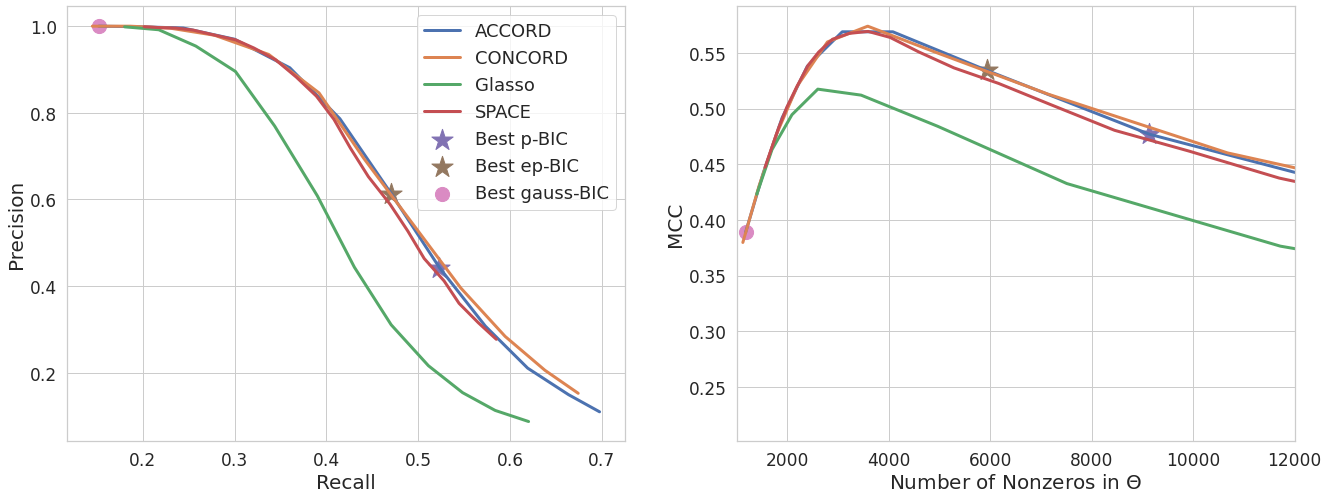

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(22, 8))
axes = axes.ravel()

i = 0
axes[i].plot(accord_recalls_hub, accord_precs_hub, linewidth=3, label='ACCORD')
axes[i].plot(concord_recalls_hub, concord_precs_hub, linewidth=3, label='CONCORD')
axes[i].plot(glasso_recalls_hub, glasso_precs_hub, linewidth=3, label='Glasso')
axes[i].plot(space_recalls_hub, space_precs_hub, linewidth=3, label='SPACE')
axes[i].scatter(accord_recalls_hub[best_p_bic_hub], accord_precs_hub[best_p_bic_hub], marker='*', s=500, color=sns.color_palette()[4], label='Best p-BIC')
axes[i].scatter(accord_recalls_hub[best_ep_bic_02_hub], accord_precs_hub[best_ep_bic_02_hub], marker='*', s=500, color=sns.color_palette()[5], label='Best ep-BIC')
axes[i].scatter(accord_recalls_hub[best_gauss_bic_hub], accord_precs_hub[best_gauss_bic_hub], marker='o', s=200, color=sns.color_palette()[6], label='Best gauss-BIC')
axes[i].set_xlabel('Recall', fontsize=20)
axes[i].set_ylabel('Precision', fontsize=20)
axes[i].tick_params(axis='both', which='major', labelsize=17)
axes[i].legend(fontsize=18)

i = 1
axes[i].plot(accord_nz_hub, accord_mccs_hub, linewidth=3, label='ACCORD')
axes[i].plot(concord_nz_hub, concord_mccs_hub, linewidth=3, label='CONCORD')
axes[i].plot(glasso_nz_hub, glasso_mccs_hub, linewidth=3, label='Glasso')
axes[i].plot(space_nz_hub, space_mccs_hub, linewidth=3, label='SPACE')
axes[i].scatter(accord_nz[best_p_bic_hub], accord_mccs_hub[best_p_bic_hub], marker='*', s=500, color=sns.color_palette()[4], label='Best p-BIC')
axes[i].scatter(accord_nz[best_ep_bic_02_hub], accord_mccs_hub[best_ep_bic_02_hub], marker='*', s=500, color=sns.color_palette()[5], label='Best ep-BIC')
axes[i].scatter(accord_nz[best_gauss_bic_hub], accord_mccs_hub[best_gauss_bic_hub], marker='o', s=200, color=sns.color_palette()[6], label='Best gauss-BIC')
axes[i].set_xlabel('Number of Nonzeros in $\Theta$', fontsize=20)
axes[i].set_ylabel('MCC', fontsize=20)
axes[i].set_xlim((1000,12000))

axes[i].tick_params(axis='both', which='major', labelsize=17);

plt.savefig('../output/precision-recall-mcc-hub-network.png', bbox_inches='tight');

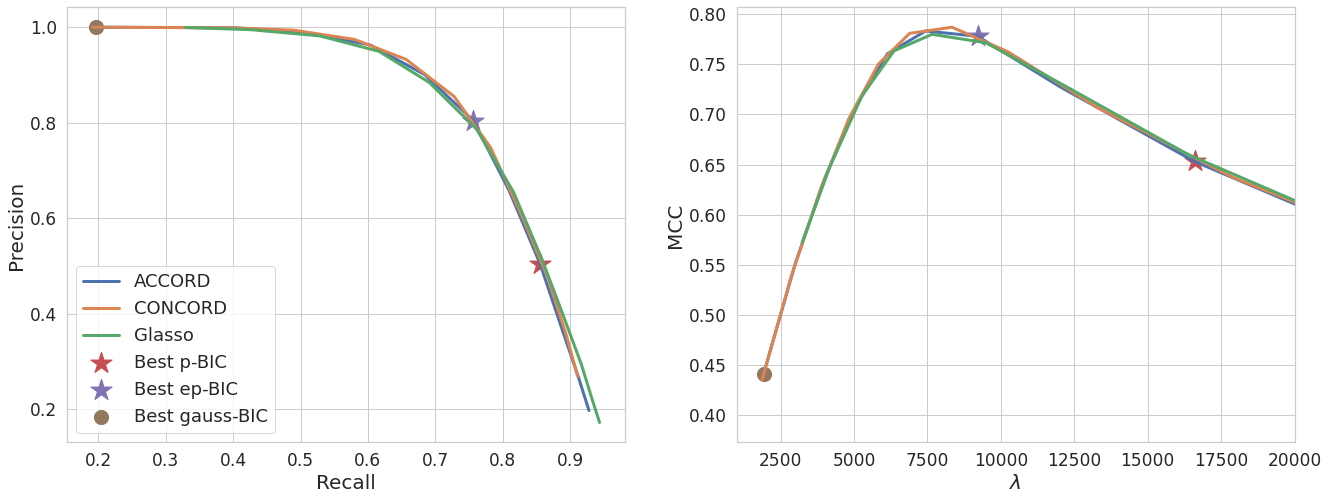

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(22, 8))
axes = axes.ravel()

i = 0
axes[i].plot(accord_recalls_er, accord_precs_er, linewidth=3, label='ACCORD')
axes[i].plot(concord_recalls_er, concord_precs_er, linewidth=3, label='CONCORD')
axes[i].plot(glasso_recalls_er, glasso_precs_er, linewidth=3, label='Glasso')
axes[i].scatter(accord_recalls_er[best_p_bic_er], accord_precs_er[best_p_bic_er], marker='*', s=500, color=sns.color_palette()[3], label='Best p-BIC')
axes[i].scatter(accord_recalls_er[best_ep_bic_02_er], accord_precs_er[best_ep_bic_02_er], marker='*', s=500, color=sns.color_palette()[4], label='Best ep-BIC')
axes[i].scatter(accord_recalls_er[best_gauss_bic_er], accord_precs_er[best_gauss_bic_er], marker='o', s=200, color=sns.color_palette()[5], label='Best gauss-BIC')
axes[i].set_xlabel('Recall', fontsize=20)
axes[i].set_ylabel('Precision', fontsize=20)
axes[i].tick_params(axis='both', which='major', labelsize=17)
axes[i].legend(fontsize=18)

i = 1
axes[i].plot(accord_nz_er, accord_mccs_er, linewidth=3, label='ACCORD')
axes[i].plot(concord_nz_er, concord_mccs_er, linewidth=3, label='CONCORD')
axes[i].plot(glasso_nz_er, glasso_mccs_er, linewidth=3, label='Glasso')
axes[i].scatter(accord_nz[best_p_bic_er], accord_mccs_er[best_p_bic_er], marker='*', s=500, color=sns.color_palette()[3], label='Best p-BIC')
axes[i].scatter(accord_nz[best_ep_bic_02_er], accord_mccs_er[best_ep_bic_02_er], marker='*', s=500, color=sns.color_palette()[4], label='Best ep-BIC')
axes[i].scatter(accord_nz[best_gauss_bic_er], accord_mccs_er[best_gauss_bic_er], marker='o', s=200, color=sns.color_palette()[5], label='Best gauss-BIC')
axes[i].set_xlabel('$\lambda$', fontsize=20)
axes[i].set_ylabel('MCC', fontsize=20)
axes[i].set_xlim((1000,20000))

axes[i].tick_params(axis='both', which='major', labelsize=17);

plt.savefig('../output/precision-recall-mcc-erdos-renyi.png', bbox_inches='tight');